# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# Install required packages
!pip install smdebug sagemaker boto3 --quiet

In [2]:
# Import required packages
import os
import sagemaker
import boto3


from sagemaker.tuner import (IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner)
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import (Rule, ProfilerRule, rule_configs, DebuggerHookConfig, ProfilerConfig, FrameworkProfile)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
role = sagemaker.get_execution_role()

In [4]:
print(f"Default Bucket: {bucket}")
print(f"RoleArn: {role}")

Default Bucket: sagemaker-us-east-1-023716343423
RoleArn: arn:aws:iam::023716343423:role/service-role/AmazonSageMaker-ExecutionRole-20250201T140675


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [5]:
# #TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget --no-check-certificate https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2025-02-05 22:53:38--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 16.15.4.134, 52.219.120.200, 52.219.120.32, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|16.15.4.134|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  45.2MB/s    in 24s     

2025-02-05 22:54:02 (45.1 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/

My S3 bucket already contains the data in the `dogImages` folder with the following structure:
s3://sagemaker-us-east-1-023716343423/dogImages/ ├── train/ ├── valid/ └── test/

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
local_dir = 'dogImages'
prefix = 'proj-3'
inputs = sagemaker_session.upload_data(path=local_dir, bucket=bucket, key_prefix=prefix)
print(f"input spec (in this case, just an S3 path): {inputs}")

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-023716343423/proj-3


In [7]:
inputs = "s3://sagemaker-us-east-1-023716343423/proj-3"
print(f"input spec (in this case, just an S3 path): {inputs}")

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-023716343423/proj-3


In [8]:
#TODO: Declare your HP ranges, metrics etc.

# Define hyperparameter ranges
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([16, 64]),
    "epochs": IntegerParameter(5, 10),
}

# Define metric definitions to capture validation loss and accuracy (these must match the logging in train_model.py)
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test Loss: ([+-]?[0-9\\.]+)"}]

# Get SageMaker execution role (ensure you have the proper permissions)
# role = sagemaker.get_execution_role()
# inputs = "s3://sagemaker-us-east-1-023716343423/dogImages"
# print(f"input spec (in this case, just an S3 path): {inputs}")

In [9]:
#TODO: Create estimators for your HPs

# Create an estimator using the hpo.py script.
estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version="py38",
    framework_version="1.9",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

tuner = HyperparameterTuner(
    estimator = estimator,
    early_stopping_type = "Auto",
    metric_definitions = metric_definitions,
    objective_metric_name = objective_metric_name,
    objective_type = objective_type,
    max_jobs = 4,
    max_parallel_jobs = 2,
    hyperparameter_ranges = hyperparameter_ranges
)

In [10]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs}, wait=True)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...........................................................................................................................................................................................................................................................................................................................................................................................................!


In [11]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2025-02-05 23:38:34 Starting - Found matching resource for reuse
2025-02-05 23:38:34 Downloading - Downloading the training image
2025-02-05 23:38:34 Training - Training image download completed. Training in progress.
2025-02-05 23:38:34 Uploading - Uploading generated training model
2025-02-05 23:38:34 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"16"',
 'epochs': '7',
 'lr': '0.05062629593835356',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2025-02-05-23-05-37-137"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-023716343423/pytorch-training-2025-02-05-23-05-37-137/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [12]:
# TODO: Set up debugging and profiling rules and hooks
hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')), \
                   "lr": best_estimator.hyperparameters()["lr"],
                   "epochs": best_estimator.hyperparameters()["epochs"],
                  }
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [13]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="train_model.py",
    framework_version="1.9",
    py_version="py38",
    role=role,
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    hyperparameters=hyperparameters,
    rules=rules,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
)

train_data = os.path.join(inputs, "train")
test_data = os.path.join(inputs, "test")
validation_data = os.path.join(inputs, "valid")

estimator.fit(
    {"train": train_data, "validation": validation_data, "test": test_data},
    wait=True
)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2025-02-05-23-39-27-244


2025-02-05 23:39:31 Starting - Starting the training job...
2025-02-05 23:39:59 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2025-02-05 23:40:19 Downloading - Downloading input data......
2025-02-05 23:41:19 Downloading - Downloading the training image........................
2025-02-05 23:45:36 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2025-02-05 23:45:28,093 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2025-02-05 23:45:28,123 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2025-02-05 23:45:28,127 sagemaker_pytorch_container.training INFO     Invoking user training script.
2025-02-05 23:45:28,417 sagemaker-training-toolkit

# Plot a debugging output

In [14]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)
description

{'TrainingJobName': 'pytorch-training-2025-02-05-23-39-27-244',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:023716343423:training-job/pytorch-training-2025-02-05-23-39-27-244',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-023716343423/pytorch-training-2025-02-05-23-39-27-244/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'batch-size': '16',
  'epochs': '"7"',
  'lr': '"0.05062629593835356"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"pytorch-training-2025-02-05-23-39-27-244"',
  'sagemaker_program': '"train_model.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-023716343423/pytorch-training-2025-02-05-23-39-27-244/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-training:1.9-gpu-py38',
  'TrainingInputMode': 'File',
  'EnableSageMakerMetricsTime

In [15]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2025-02-05 23:55:15.270 default:2311 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-02-05 23:55:15.327 default:2311 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-023716343423/pytorch-training-2025-02-05-23-39-27-244/debug-output


INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


[2025-02-05 23:55:15.813 default:2311 WARNING s3handler.py:184] Encountered the exception [SYS] unknown error (_ssl.c:2580) while reading s3://sagemaker-us-east-1-023716343423/pytorch-training-2025-02-05-23-39-27-244/debug-output/index/000000000/000000000938_worker_0.json . Will retry now


INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sh

In [16]:
trial.tensor_names()

[2025-02-05 23:55:19.878 default:2311 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2025-02-05 23:55:20.894 default:2311 INFO trial.py:210] Loaded all steps


['cross_entropy_loss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [17]:
len(trial.tensor("cross_entropy_loss_output_0").steps(mode=ModeKeys.TRAIN))

5

In [18]:
len(trial.tensor("cross_entropy_loss_output_0").steps(mode=ModeKeys.EVAL))

294

In [19]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    print(f"[INFO] Getting data in {len(steps)} steps")
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
        print(".", end="")
    return steps, vals

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(20, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

INFO:matplotlib.font_manager:generated new fontManager


INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


[INFO] Getting data in 5 steps
.

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..loaded TRAIN data
[INFO] Getting data in 294 steps


INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


.

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


...

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


..

INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].


.loaded EVAL data
completed TRAIN plot
completed EVAL plot


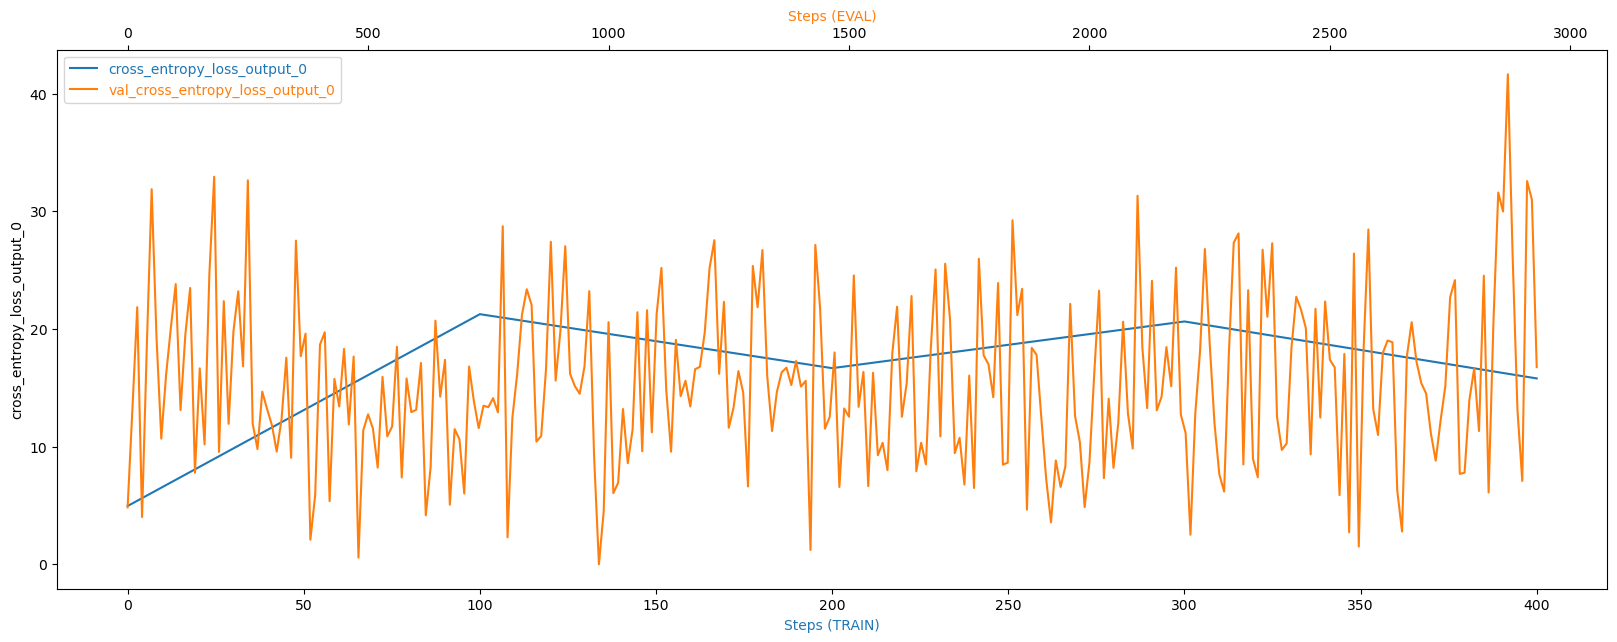

In [21]:
plot_tensor(trial, "cross_entropy_loss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

# Display the profiler output

In [22]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [23]:
! aws s3 ls {rule_output_path} --recursive

2025-02-05 23:54:56     404827 pytorch-training-2025-02-05-23-39-27-244/rule-output/ProfilerReport/profiler-output/profiler-report.html
2025-02-05 23:54:55     258281 pytorch-training-2025-02-05-23-39-27-244/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2025-02-05 23:54:50        594 pytorch-training-2025-02-05-23-39-27-244/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2025-02-05 23:54:50      16271 pytorch-training-2025-02-05-23-39-27-244/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2025-02-05 23:54:50       2092 pytorch-training-2025-02-05-23-39-27-244/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2025-02-05 23:54:50        130 pytorch-training-2025-02-05-23-39-27-244/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2025-02-05 23:54:50       1411 pytorch-training-2025-02-05-23-39-27-244/rule-output/ProfilerReport/profiler-output/profiler-re

In [24]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-023716343423/pytorch-training-2025-02-05-23-39-27-244/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-023716343423/pytorch-training-2025-02-05-23-39-27-244/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-023716343423/pytorch-training-2025-02-05-23-39-27-244/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-023716343423/pytorch-training-2025-02-05-23-39-27-244/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-023716343423/pytorch-training-2025-02-05-23-39-27-244/rul

In [25]:
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [26]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [35]:
from sagemaker.pytorch import PyTorchModel

In [61]:
model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
print(f"Model: {model_data}")

Model: s3://sagemaker-us-east-1-023716343423/pytorch-training-2025-02-05-23-39-27-244/output/model.tar.gz


In [62]:
pytorch_model = PyTorchModel(
    model_data=model_data, 
    role=role, 
    entry_point='inference.py',
    py_version="py38",
    framework_version="1.9"
)

In [63]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.large")

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-023716343423/pytorch-training-2025-02-05-23-39-27-244/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-023716343423/pytorch-inference-2025-02-06-02-02-54-739/model.tar.gz. This may take some time depending on model size...
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation.

-------!

In [74]:
data_dir = "dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00309.jpg"

In [75]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

In [76]:
# # Preprocessing the image
# data_dir = "dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00309.jpg"
# image = Image.open(data_dir).convert("RGB")

# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
# ])

In [77]:
preprocessed_image = transform(image).unsqueeze(0).to("cpu").numpy().tolist()
print(np.array(preprocessed_image).shape)  # This should print (1, 3, 224, 224)


(1, 3, 224, 224)


In [78]:
# image = Image.open(data_dir)
# transform = transforms.Compose([
#             transforms.Resize((224, 224)),
#             transforms.ToTensor(),
#         ])
# preprocessed_image = transform(image).unsqueeze(0)
# preprocessed_image = preprocessed_image.to("cpu")
# response = predictor.predict(preprocessed_image)

# # pred = np.argmax(response, 1) + 1

# # actual = int(image_path.split('.')[1].split('/')[-1])
# # print(f"Actual: {actual}, Prediction: {pred[0]}")

image = Image.open(data_dir).convert("RGB")
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure consistent dimensions
    transforms.ToTensor(),
])

# preprocessed_image = transform(image).unsqueeze(0)
# preprocessed_image = preprocessed_image.to("cpu").numpy().tolist()

response = predictor.predict(preprocessed_image)

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2025-02-06-02-03-00-430 in account 023716343423 for more information.

In [27]:
predictor = tuner.deploy(initial_instance_count=1, instance_type="ml.t2.medium")


2025-02-05 23:38:34 Starting - Found matching resource for reuse
2025-02-05 23:38:34 Downloading - Downloading the training image
2025-02-05 23:38:34 Training - Training image download completed. Training in progress.
2025-02-05 23:38:34 Uploading - Uploading generated training model
2025-02-05 23:38:34 Completed - Resource released due to keep alive period expiry

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-023716343423/pytorch-training-250205-2305-003-cbcb0db1/output/model.tar.gz), script artifact (s3://sagemaker-us-east-1-023716343423/pytorch-training-2025-02-05-23-05-37-137/source/sourcedir.tar.gz), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-023716343423/pytorch-training-2025-02-05-23-56-09-145/model.tar.gz. This may take some time depending on model size...


INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sha256'].
INFO:botocore.httpchecksum:Skipping checksum validation. Response did not contain one of the following algorithms: ['crc32', 'sha1', 'sh

--------------!

In [34]:
# Path to your image
data_dir = "dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00309.jpg"

with open(data_dir, "rb") as f:
    image_bytes = f.read()

# Invoke the endpoint
response = predictor.predict(image_bytes, initial_args={"ContentType": "image/jpeg"})

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-training-250205-2305-003-cbcb0db1 in account 023716343423 for more information.

In [29]:
# from PIL import Image
# import numpy as np

# # Path to your image
# image_path = "./dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00309.jpg"

# with open(image_path, "rb") as f:
#     image_bytes = f.read()

# # Invoke the endpoint
# response = predictor.predict(image_bytes, initial_args={"ContentType": "image/jpeg"})

# # Process the response
# pred = np.argmax(response, axis=1) + 1

# # (Optionally) extract actual label from your image path if that is your naming convention
# actual = int(image_path.split('.')[1].split('/')[-1])
# print(f"Actual: {actual}, Prediction: {pred[0]}")


ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-training-250202-2119-001-ec587780 in account 023716343423 for more information.

### End Note to Reviewer.

I have tried to resolve this issue, but no matter what I do, this error keeps reoccurring. As can be seen in the cells below, I have tried in multiple ways to query the endpoint, I have created other files (inference.py, Dockerfile - probably wrong), as well as changed the code several times in order to resolve this error, but it doesn't seem solvable.

I was able to deploy the model, so everything is done. It's just this last part that keeps giving me issues.

I have raised this issue on the course's knowledge and help site, but await a response.

I consider this project completed, as I have completed every requirement and I have tried to complete this Endpoint query too. After being stuck on this for 2 days, I conclude. 

Please review this project as completed, for it is. I await your feedback. Thank you.

In [ ]:
# # from sagemaker.predictor import Predictor
# # jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
# # json_deserializer = sagemaker.deserializers.JSONDeserializer()


# # class ImagePredictor(Predictor):
# #     def __init__(self, endpoint_name, sagemaker_session):
# #         super(ImagePredictor, self).__init__(
# #             endpoint_name,
# #             sagemaker_session=sagemaker_session,
# #             serializer=jpeg_serializer,
# #             deserializer=json_deserializer,
# #         )


# from sagemaker.pytorch import PyTorchModel

# model_data = estimator.output_path + estimator.latest_training_job.job_name + "/output/model.tar.gz"
# print(f"Model: {model_data}")

In [ ]:
# # from sagemaker.pytorch import PyTorchModel
# # pytorch_model = PyTorchModel(model_data=estimator.model_data, role=role, entry_point='inference.py',py_version='py38',
# #                              framework_version='1.9',
# #                              predictor_cls=ImagePredictor)


# pytorch_model = PyTorchModel(
#     model_data=estimator.model_data,
#     role=role,
#     entry_point='inference.py',
#     py_version='py36',
#     framework_version='1.8',
#     # env={"TS_DISABLE_GPU_METRICS": "True"}  # Disable GPU metrics
# )


In [ ]:
# predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.m5.large")

In [ ]:
# import boto3

# s3_client = boto3.client('s3')
# presigned_url = s3_client.generate_presigned_url(
#     'get_object',
#     Params={'Bucket': 'sagemaker-us-east-1-023716343423', 'Key': 'proj-3/test/005.Alaskan_malamute/Alaskan_malamute_00309.jpg'},
#     ExpiresIn=3600  # Valid for 1 hour
# )
# print(presigned_url)


In [ ]:
# import requests
# import io
# from PIL import Image

# img_bytes = requests.get(presigned_url).content
# img = Image.open(io.BytesIO(img_bytes))
# img.show()  # or process as needed


In [ ]:
# response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [ ]:
# !pip install torchvision -q
# !pip install nvgpu

In [ ]:
# from PIL import Image
# import numpy as np
# import torchvision.transforms as transforms

# image_path = "./dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00309.jpg"

In [ ]:
# with open(image_path, "rb") as f:
#     image_bytes = f.read()


# response = predictor.predict(image_bytes, initial_args={"ContentType": "image/jpeg"})
# pred = np.argmax(response, axis=1) + 1

# actual = int(image_path.split('.')[1].split('/')[-1])
# print(f"Actual: {actual}, Prediction: {pred[0]}")

### Unable to 

In [ ]:
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# import torchvision.transforms as transforms
# from sagemaker.serializers import NumpySerializer


In [ ]:
# image_path = "./dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00309.jpg"

In [ ]:
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# import torchvision.transforms as transforms

# image_path = "./dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00309.jpg"

# image = Image.open(image_path)
# transform = transforms.Compose([
#             transforms.Resize(224),
#             transforms.ToTensor(),
#         ])
# preprocessed_image = transform(image).unsqueeze(0)
# preprocessed_image = preprocessed_image.to("cpu")
# response = predictor.predict(preprocessed_image)

# pred = np.argmax(response, 1) + 1

# actual = int(image_path.split('.')[1].split('/')[-1])
# print(f"Actual: {actual}, Prediction: {pred[0]}")

In [ ]:
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# import torchvision.transforms as transforms

# # Read the image as raw bytes
# image_path = "./dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00309.jpg"
# with open(image_path, "rb") as f:
#     image_bytes = f.read()

# # Invoke the endpoint, telling it that the content type is JPEG
# response = predictor.predict(image_bytes, initial_args={"ContentType": "image/jpeg"})

# # Process the response (this depends on what your predict_fn returns)
# pred = np.argmax(response, axis=1) + 1

# # Extract actual label from file path (if that naming convention is used)
# actual = int(image_path.split('.')[1].split('/')[-1])
# print(f"Actual: {actual}, Prediction: {pred[0]}")




# from PIL import Image
# import numpy as np
# import torchvision.transforms as transforms

# image_path = "./dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00309.jpg"
# with open(image_path, "rb") as f:
#     image_bytes = f.read()

# response = predictor.predict(image_bytes, initial_args={"ContentType": "image/jpeg"})
# pred = np.argmax(response, axis=1) + 1

# actual = int(image_path.split('.')[1].split('/')[-1])
# print(f"Actual: {actual}, Prediction: {pred[0]}")


In [ ]:
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt
# import torchvision.transforms as transforms
# from sagemaker.serializers import NumpySerializer

# # Load and preprocess the image
# image_path = "./dogImages/test/005.Alaskan_malamute/Alaskan_malamute_00309.jpg"
# image = Image.open(image_path)
# transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.ToTensor(),
# ])
# preprocessed_image = transform(image).unsqueeze(0)

# # Convert tensor to numpy array
# input_array = preprocessed_image.cpu().numpy()

# # Set the predictor's serializer to NumpySerializer
# predictor.serializer = NumpySerializer()

# # Invoke the endpoint with the numpy array; set ContentType to application/json
# response = predictor.predict(input_array, initial_args={"ContentType": "application/json"})

# # Process the response
# pred = np.argmax(response, axis=1) + 1

# actual = int(image_path.split('.')[1].split('/')[-1])
# print(f"Actual: {actual}, Prediction: {pred[0]}")


# # image = Image.open(image_path)
# # transform = transforms.Compose([
# #     transforms.Resize(224),
# #     transforms.ToTensor(),
# # ])
# # preprocessed_image = transform(image).unsqueeze(0)

# # # Convert tensor to numpy array and then to raw bytes
# # input_array = preprocessed_image.cpu().numpy()
# # input_bytes = input_array.tobytes()

# # # Set the serializer to pass through the bytes as-is
# # predictor.serializer = IdentitySerializer("application/octet-stream")

# # # Try invoking the endpoint with the raw bytes
# # response = predictor.predict(input_bytes)

# # # Process the response (adjust as needed)
# # pred = np.argmax(response, axis=1) + 1

# # actual = int(image_path.split('.')[1].split('/')[-1])
# # print(f"Actual: {actual}, Prediction: {pred[0]}")


In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
# predictor.delete_endpoint()